# Tensor Decompositions

In [3]:
'''
Imports
'''
proj_dir = '/Users/prabh/200 RESEARCH/Cluster Expansion Project'

# gives the notebook access to the cluster_expansion personal library
from sys import path
path.append(proj_dir)
import cluster_expansion as ce
from cluster_expansion import os, pd, np, plt, sns, tf, Markdown, display, train_test_split

import tensorly as tl

/Users/prabh/200 RESEARCH/Cluster Expansion Project/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
seqs = '100M'
tensor_dir = f'../InteractionTensors/{seqs} Sequences/Symmetric'
consolidated = True
comb = 'C' if consolidated else ''

if consolidated:
  G = np.load(f'{tensor_dir}/GC_{seqs}.npy')
else:
  G = np.load(f'{tensor_dir}/G_{seqs}.npy')

In [94]:
from tensorly.decomposition import tucker, parafac, symmetric_parafac_power_iteration, power_iteration, symmetric_power_iteration

In [95]:
PCA_dir = f'../Data/PCA/Synthetic/G{comb}'

## Tucker

In [96]:
# performing the G tucker decomposition
Gcore, factors = tucker(G, rank=[200, 200, 200])
factors = np.array(factors)

In [97]:
# interactive 3D slices
import napari
vmax = np.percentile(np.abs(Gcore), 99)
try:
    viewer = napari.Viewer()
    viewer.add_image(Gcore, name='G', colormap='bwr', contrast_limits=[-vmax, vmax])
    napari.run()
except Exception as e:
    print(e)
    pass

In [98]:
s1 = Gcore[:, :, 0]
evals_s1, evecs_s1 = np.linalg.eigh(s1)
# sort by value (descending), not by absolute value
order = np.argsort(evals_s1)[::-1]
evals_s1 = evals_s1[order]
evecs_s1 = evecs_s1[:, order]

eigval0 = evals_s1[0]
eigvec0 = evecs_s1[:, 0]

print("Top eigenvalue:", eigval0)

Top eigenvalue: 0.26595455


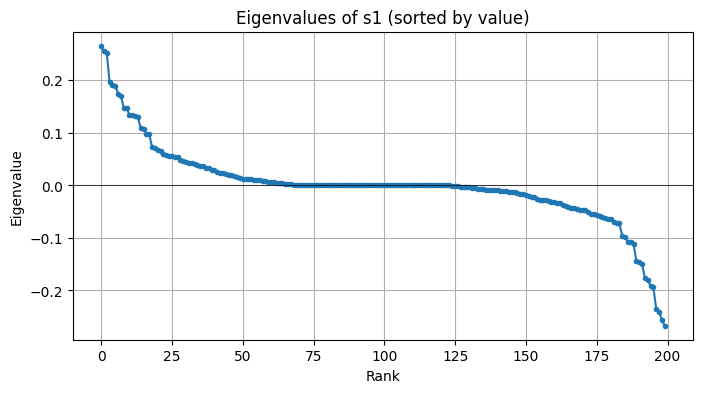

In [99]:
# plot eigenvalues of s1 sorted by value (descending)
sorted_idx = np.argsort(evals_s1)[::-1]
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(evals_s1)), evals_s1[sorted_idx], marker='o', markersize=3, linestyle='-')
plt.title('Eigenvalues of s1 (sorted by value)')
plt.xlabel('Rank')
plt.ylabel('Eigenvalue')
plt.axhline(0, color='k', linewidth=0.5)
plt.grid(True)
plt.show()

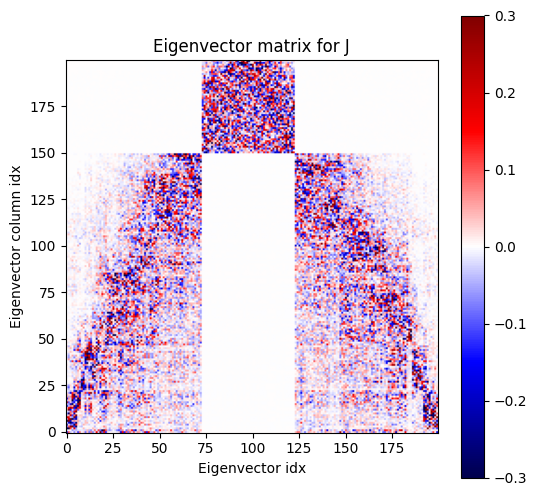

In [100]:
# plotting the eigenvectors corresponding to the descending order eigenvalues

Vmin, Vmax = (-0.3, 0.3)
plt.figure(figsize=(6, 6))
plt.imshow(evecs_s1, vmin=Vmin, vmax=Vmax, cmap='seismic', origin='lower')
plt.colorbar()
plt.title('Eigenvector matrix for J')
plt.xlabel('Eigenvector idx')
plt.ylabel('Eigenvector column idx')
plt.show()

Gcore is a 200 x 200 x 200 tensor where larger values are an analogue to the 'energy' contained at that index <br>

<br>

Gfactors is a 3 x 200 x 200 tensor containing an analogue to 'eigenvectors' for the G tensor <br>
* For this symmetric G tensor, all the factor matrices are equal

In [53]:
print(type(Gcore), type(factors))
print(Gcore.shape, factors.shape)

are_equal = np.allclose(factors[0], factors[1]) and np.allclose(factors[1], factors[2])
print("All Gfactors are equal:", are_equal)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(200, 200, 200) (3, 200, 200)
All Gfactors are equal: False


In [54]:
# measuring reconstruction error

Gtucker_rec = tl.tucker_to_tensor((Gcore, factors))

# measure reconstruction error with frobenius norm
recError = np.linalg.norm(G - Gtucker_rec) / np.linalg.norm(G)
print(f'Reconstruction Error: {recError:.6f}%')

Reconstruction Error: 0.000001%


Tucker decomposotion can fully reconstruct the original G tensor

Text(0, 0.5, 'row index')

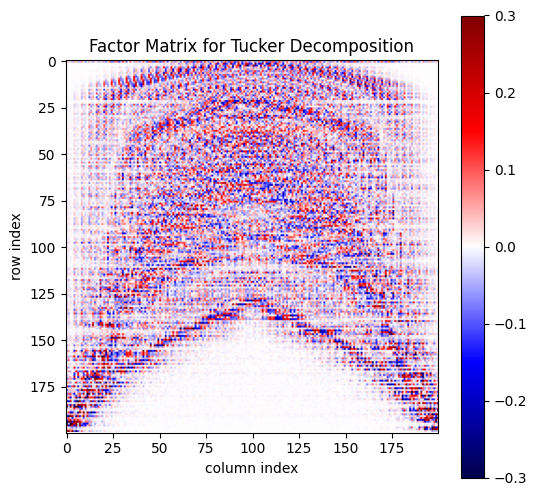

In [ ]:
Vmin, Vmax = (-0.3, 0.3)
plt.figure(figsize = (6, 6))
plt.imshow(factors[0].T, vmin = Vmin, vmax = Vmax, cmap = 'seismic')
plt.colorbar()
plt.title('Factor Matrix for Tucker Decomposition')
plt.xlabel('column index')
plt.ylabel('row index')

In the above image, rows represent eigenvectors

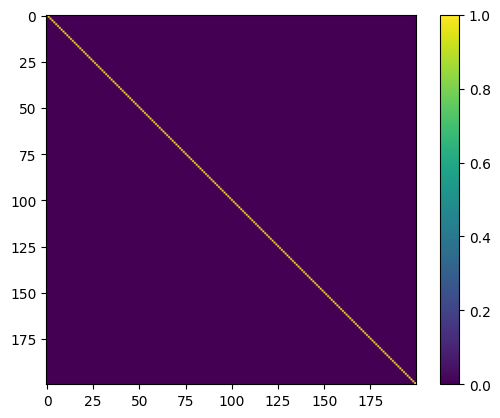

In [56]:
matrix = np.zeros([200,200])
for i in range(200):
  for j in range(200):
    matrix[i][j] = np.dot(factors[0][i], factors[0][j])

plt.imshow(matrix)
plt.colorbar()


### Low-rank tucker decomposition

In [61]:
rank = 2
Gcore, factors = tucker(G, rank=[rank, rank, rank])
factors = np.array(factors)

are_equal = np.allclose(factors[0], factors[1]) and np.allclose(factors[1], factors[2])
print("All factors are equal:", are_equal)
print(f"Gcore shape: {Gcore.shape}")
print(f"Factors shape: {factors.shape}")

# Create a pandas DataFrame for the factors
df_factors = pd.DataFrame({
  'Factor_0': factors[0].flatten(),
  'Factor_1': factors[1].flatten(), 
  'Factor_2': factors[2].flatten()
})

print(df_factors.head())

All factors are equal: False
Gcore shape: (2, 2, 2)
Factors shape: (3, 200, 2)
   Factor_0  Factor_1  Factor_2
0 -0.012786 -0.012931 -0.013440
1  0.014957  0.014781  0.014916
2 -0.003473 -0.003218 -0.003121
3  0.012671  0.012898  0.013267
4  0.027896  0.027979  0.028149


In [ ]:
# projecting the eigenvectors of the G tensor as sequences

save = False
if save:
    with open(f'{PCA_dir}/tucker:rank={rank}.dat', 'w') as f:
        for eigvect in factors[0].T:
            f.write(f'{ce.Project2Sequence(eigvect)}\n')

## Parafac

In [24]:
weights, factors = parafac(G, rank = 200, normalize_factors = True, orthogonalise = True)

factors = np.array(factors)

In [25]:
print(type(weights), type(factors))
print(weights.shape, factors.shape)

are_equal = np.allclose(factors[0], factors[1]) and np.allclose(factors[1], factors[2])
print("All factors are equal:", are_equal)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(200,) (3, 200, 200)
All factors are equal: False


Weights are essentially 200 'eigenvalues', and factors are essentially 3 sets of 200 'eigenvector' analogues <br>

<br>

The three factor matrices ARE NOT equal, imaging required

In [26]:
# measuring reconstruction error

Gcp_rec = tl.cp_to_tensor((weights, factors))

# measure reconstruction error with frobenius norm
recError = np.linalg.norm(G - Gcp_rec) / np.linalg.norm(G)
print(f'Reconstruction Error: {recError:.6f}%')

Reconstruction Error: 0.330567%


cp decomposition cannot fully reconstruct the G tensor

NameError: name 'Vmin' is not defined

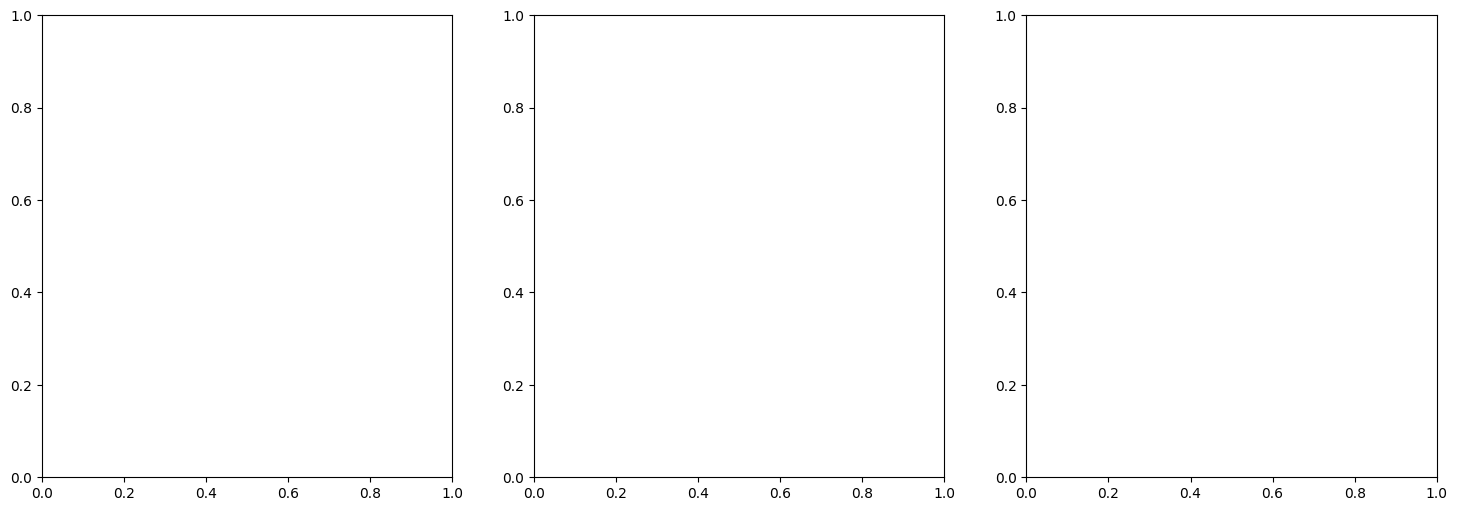

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, ax in enumerate(axes):
    im = ax.imshow(factors[i].T, vmin=Vmin, vmax=Vmax, cmap='seismic')
    ax.set_title(f'Factor Matrix {i+1} for parafac Decomposition')
    ax.set_xlabel('column index')
    ax.set_ylabel('row index')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


The factor matrices appear very similar, probably inequal due to small differences

In [ ]:
# projecting the eigenvectors of the G tensor as sequences
#with open(f'{directory}/parafac.txt', 'w') as f:
#    for eigvect in factors[0].T:
#        f.write(f'{Project2Sequence(eigvect)}\n')

## Symmetric Parafac Power Iteration

In [31]:
rank = 200
weights, factor = symmetric_parafac_power_iteration(G, rank = rank)

In [29]:
print(type(weights), type(factor))
print(weights.shape, factor.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1,) (200, 1)


**RUNTIME**: 5 MINUTES

Creates a set of 200 'eigenvalues' and corresponding 'eigenvectors'

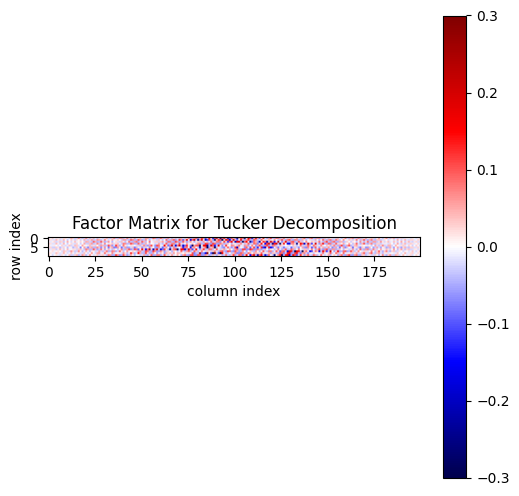

In [58]:
import seaborn as sns

if rank > 5:
    Vmin, Vmax = (-0.3, 0.3)
    plt.figure(figsize = (6, 6))
    plt.imshow(factor.T, vmin = Vmin, vmax = Vmax, cmap = 'seismic')
    plt.colorbar()
    plt.title('Factor Matrix for Tucker Decomposition')
    plt.xlabel('column index')
    plt.ylabel('row index')
    plt.show()
else:
    bases_order = ['A', 'T', 'C', 'G']
    eigvecs2print = list(range(factor.shape[1]))  # Only plot as many as the rank

    # If factor is 2D (n, k), use factor[:, mode], else flatten
    for mode in eigvecs2print:
        plt.figure(figsize=(8, 4))
        if factor.ndim == 2:
            # Only use mode if it is within bounds
            if mode < factor.shape[1]:
                evect = factor[:, mode].flatten()
            else:
                evect = factor[:, 0].flatten()
        else:
            evect = factor.flatten()
        mat = evect.reshape(-1, 4)

        sns.heatmap(
            mat.T,
            cmap='coolwarm',
            center=0,
            vmin=-0.1,
            vmax=0.1,
            linewidths=0.3,
            linecolor='lightgrey',
            yticklabels=bases_order
        )
        plt.title(f"Mode {mode+1}")
        plt.xlabel("Position i_alpha")
        plt.ylabel("Base")
        plt.show()

In [ ]:
# projecting the eigenvectors of the G tensor as sequences

#with open(f'{directory}/symPPI_rank={rank}.txt', 'w') as f:
#    for eigvect in factor.T:
#        f.write(f'{Project2Sequence(eigvect)}\n')

## Power Iteration

In [ ]:
eigenval, factors, _ = power_iteration(G, n_iteration=100)

factors = np.array(factors)

In [ ]:
print(type(eigenval), type(factors))
print(eigenval.shape, factors.shape)

are_equal = np.allclose(factors[0], factors[1]) and np.allclose(factors[1], factors[2])
print("All Gfactors are equal:", are_equal)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([]) torch.Size([3, 200])
All Gfactors are equal: False


While the 'bestFactors' contain 3 slightly different 'eigenvectors', they all project to the same sequence

In [ ]:
# project sequences of the eigenvectors

iters = 50

with open(f'{directory}/powerIteration.txt', 'w') as f:
    for i in range(iters):
        eigenval, factors, _ = power_iteration(G, n_iteration=100)
        factors = np.array(factors)
        f.write(f'{Project2Sequence(eigvect)}\n')

## Symmetric Power Iteration

In [65]:
eigenval, factors, _ = symmetric_power_iteration(G, n_iteration=10)

In [66]:
print(type(eigenval), type(factors))
print(eigenval.shape, factors.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
() (200,)


Returns 1 eigenvalue and eigenvector

In [ ]:
# project sequences of the eigenvectors

iters = 5

with open(f'{directory}/SymPI_iters={iters}.txt', 'w') as f:
    for i in range(iters):
        eigenval, factors, _ = symmetric_power_iteration(G, n_iteration=10)
        eigvect = factors
        f.write(f'{Project2Sequence(eigvect)}\n')

## HOPM

In [78]:
def hopm_tensor_eigen(G, max_iters=500, tol=1e-6, track_convergence=False, minimize=False):
    n = G.shape[0]
    x = np.random.randn(n)
    x /= np.linalg.norm(x, ord=3)
    
    eigenvalues = [] if track_convergence else None

    for _ in range(max_iters):
        x_old = x.copy()

        y = np.tensordot(G, np.outer(x, x), axes=([1,2], [0,1]))
        if minimize:
            y = -y
        
        x = np.sign(y) * np.sqrt(np.abs(y))
        x /= np.linalg.norm(x, ord=3)
        
        if track_convergence:
            eigenvalue = np.einsum('ijk,i,j,k', G, x, x, x)
            eigenvalues.append(eigenvalue) # type: ignore

        if np.linalg.norm(x - x_old) < tol:
            break

    eigenvalue = np.einsum('ijk,i,j,k', G, x, x, x)
    return (eigenvalue, x, eigenvalues) if track_convergence else (eigenvalue, x)

def hopm_multiple_starts(G, num_runs=10, minimize=False):
    best_eigenvalue = -np.inf if not minimize else np.inf
    best_eigenvector = None
    all_eigenvalues = []

    for _ in range(num_runs):
        eigenvalue, eigenvector = hopm_tensor_eigen(G, minimize=minimize) #type: ignore
        all_eigenvalues.append(eigenvalue)
        if minimize:
            if eigenvalue < best_eigenvalue:
                best_eigenvalue = eigenvalue
                best_eigenvector = eigenvector
        else:
            if eigenvalue > best_eigenvalue:
                best_eigenvalue = eigenvalue
                best_eigenvector = eigenvector

    return best_eigenvalue, best_eigenvector, all_eigenvalues

In [ ]:
N = 5
eigenvalues = []
eigenvectors = []

MIN = True 

for i in range(N):
    n = 100
    # Perform HOPM decomposition with multiple starts
    best_eigenvalue, best_eigenvector, all_eigenvalues = hopm_multiple_starts(G, num_runs=n, minimize=MIN)
    eigenvalues.append(best_eigenvalue)
    eigenvectors.append(best_eigenvector)

    print(f'eigv: {best_eigenvalue}')
    print(f'eigh size: {best_eigenvector.shape}') # type: ignore
    print()

# Convert results to numpy arrays
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

# Print the best eigenvalue
print(f"Best Eigenvalue: {min(eigenvalues):.2f}") # type: ignore

eigv: -1.5559484590555317
eigh size: (200,)

eigv: -1.3857052291860765
eigh size: (200,)

eigv: -1.4709151395207039
eigh size: (200,)

eigv: -1.3407575209136655
eigh size: (200,)

eigv: -1.4524514875661378
eigh size: (200,)



NameError: name 'eigenvalue' is not defined

In [82]:
with open(f"{directory}/hopm{'Min' if MIN else 'Max'}.txt", 'a') as f:
    for i in range(len(eigenvalues)):
        eigenvector_reshaped = Project2Sequence(eigenvectors[i])
        f.write(f'{eigenvector_reshaped}\n')